In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.returns import MarketReturns, AlphaSource
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import SinglePeriodOpt, Hold
from cvx_portfolio.data import generate_alpha_signal, series_factor_model_covariance
from cvx_portfolio.risks import EmpSigma, FactorModelSigma
from cvx_portfolio.constraints import LeverageLimit  


plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

## Download data using ee103 code (to be integrated) 

In [2]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])

In [3]:
np.random.seed(1)
alpha_signal=generate_alpha_signal(real_returns=returns, IC=0.01, type_noise='OU')
alpha_signal = 0.01 * alpha_signal
alpha_signal.USDOLLAR = returns.USDOLLAR

alpha_model = AlphaSource(alpha_signal)

/home/enzo/repos/cvx_portfolio/cvx_portfolio/data/generator.py:30: RuntimeWarning: overflow encountered in exp
  sig*ex*np.concatenate([[0],np.cumsum(np.sqrt(np.diff(np.exp(2*th*t)-1))*np.random.randn(len(t)-1))])
/home/enzo/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:1578: RuntimeWarning: invalid value encountered in subtract
  return a[slice1]-a[slice2]


### Compute factor risk model 

In [4]:
exposures_pan, factor_sigma_pan, idyos_df = series_factor_model_covariance(returns, 
                                                                           variance_explained=.6,
                                                                           freq='MS',
                                    lookback_periods = 12)

#risk_model = EmpSigma(returns, lookback=500)
risk_model = FactorModelSigma(exposures_pan, factor_sigma_pan, idyos_df)

### Transaction costs model

In [5]:
del volumes['USDOLLAR']
del sigmas['USDOLLAR']

spread = pd.DataFrame(data=5e-4, index=volumes.index, columns=volumes.columns)
nonlin_coeff = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns)
simulated_tcost = TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')

## Market simulator 

In [6]:
simulator = MarketSimulator(MarketReturns(returns), volumes, [simulated_tcost], cash_key='USDOLLAR')

## Portfolio

In [7]:
p = pd.Series(index=returns.columns, data=1)/len(returns.columns)
weights=p/sum(p)
p_0 = 1E8*p

## Policy

In [8]:
# larger than .4 we almost don't trade.
gamma_tcosts = [0., 20., 30., 40., 50]
gamma_tcosts

[0.0, 20.0, 30.0, 40.0, 50]

In [9]:
# values smaller than .3 give basically same result as with 0. 
#gamma_risks = np.logspace(-.5,1,3)
gamma_risks = [0., 1., 10., 50., 100., 1000.] 
gamma_risks

[0.0, 1.0, 10.0, 50.0, 100.0, 1000.0]

In [10]:
policies={}
for gamma_risk in gamma_risks:
    for gamma_tcost in gamma_tcosts:
        policies[(gamma_risk, gamma_tcost)] = \
                SinglePeriodOpt(alpha_model, [gamma_risk*risk_model, gamma_tcost*simulated_tcost], [LeverageLimit(3)])

## Simulations

In [11]:
five_years=returns.index[(returns.index>"2012-01-01")] # "2012-01-01"
results_raw = simulator.run_multiple_backtest(p_0, five_years, policies=policies.values(), parallel=True)
results=dict(zip(policies.keys(), results_raw))

In [12]:
result_df=pd.DataFrame()
for k in results:
    result_df.loc[k[0], k[1]] = results[k]
result_df.index.name = 'gamma_risk'
result_df.columns.name = 'gamma_tcost'
result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))

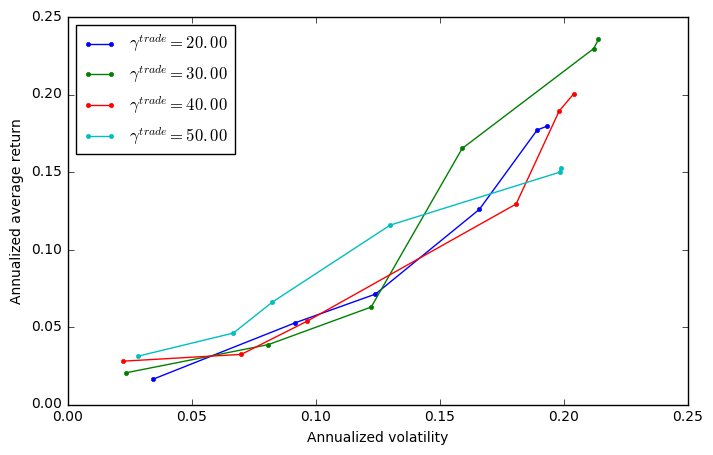

In [13]:
plt.figure(figsize=(8,5))
for gamma_tcost in gamma_tcosts[1:]:
    #plt.figure()
    x = [result_df.loc[(i, gamma_tcost)].volatility for i in gamma_risks]
    y = [result_df.loc[(i, gamma_tcost)].mean_return for i in gamma_risks]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^{trade} = %.2f$'%gamma_tcost)
plt.legend(loc='upper left')
plt.xlabel('Annualized volatility')
plt.ylabel('Annualized average return')
plt.savefig(plotdir+'spo_riskrewardfrontier.png')

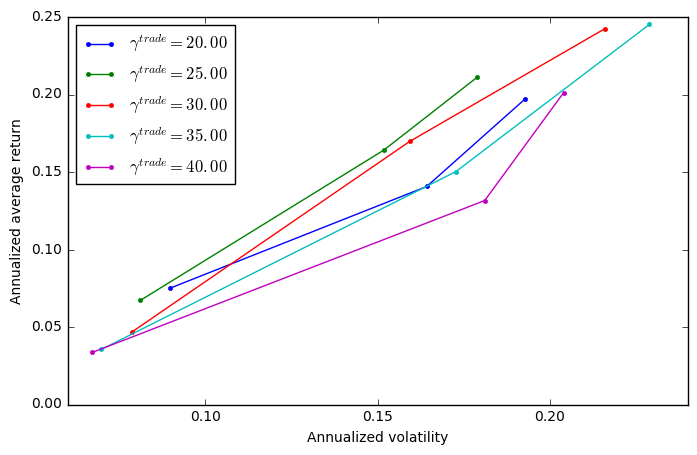

In [13]:
plt.figure(figsize=(8,5))
for gamma_tcost in gamma_tcosts[1:]:
    #plt.figure()
    x = [result_df.loc[(i, gamma_tcost)].volatility for i in gamma_risks]
    y = [result_df.loc[(i, gamma_tcost)].mean_return for i in gamma_risks]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^{trade} = %.2f$'%gamma_tcost)
plt.legend(loc='upper left')
plt.xlabel('Annualized volatility')
plt.ylabel('Annualized average return')
plt.savefig(plotdir+'spo_riskrewardfrontier.png')

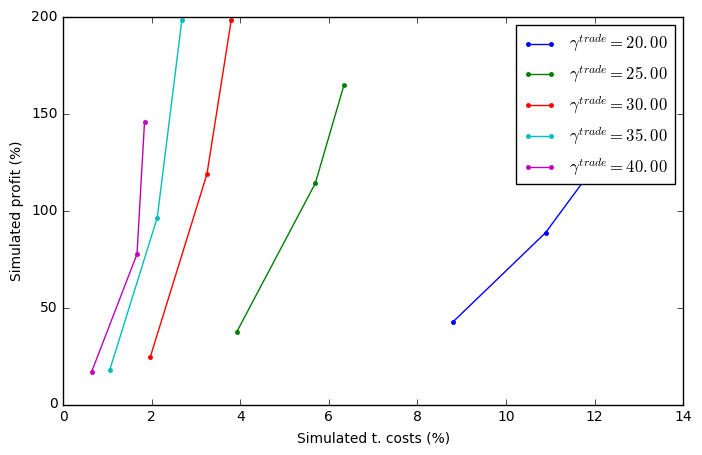

In [14]:
init_val = 100E6
plt.figure(figsize=(8,5))
for gamma_tcost in gamma_tcosts[1:]:
    #plt.figure()
    x = [100*result_df.loc[(i, gamma_tcost)].simulator_TcostModel.sum().sum()/init_val for i in gamma_risks]
    y = [100*result_df.loc[(i, gamma_tcost)].profit/init_val for i in gamma_risks]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^{trade} = %.2f$'%gamma_tcost)
plt.legend(loc='upper right')
plt.xlabel("Simulated t. costs (%)")
plt.ylabel("Simulated profit (%)")
plt.savefig(plotdir+'spo_profittcost.png')

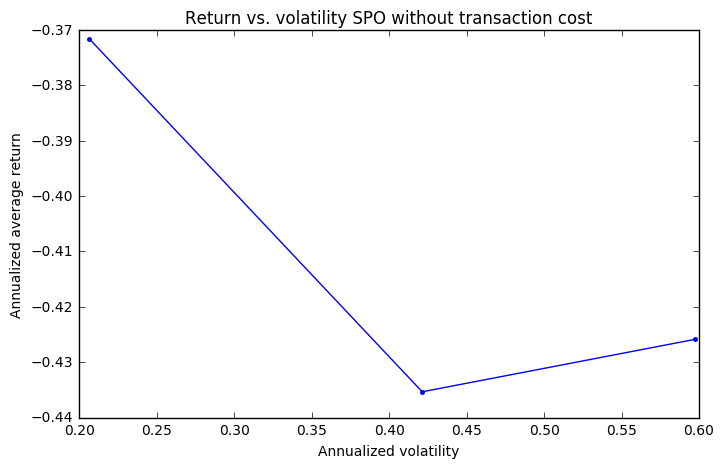

In [15]:
plt.figure(figsize=(8,5))
for gamma_tcost in gamma_tcosts[:1]:
    #plt.figure()
    x = [result_df.loc[(i, gamma_tcost)].volatility for i in gamma_risks]
    y = [result_df.loc[(i, gamma_tcost)].mean_return for i in gamma_risks]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^{trade} = %.2f$'%gamma_tcost)
#plt.legend(loc='upper left')
plt.xlabel('Annualized volatility')
plt.ylabel('Annualized average return')
plt.title('Return vs. volatility SPO without transaction cost')
plt.savefig(plotdir+'spo_zerotcost_riskrewardfrontier.png')

In [14]:
result_df.applymap(lambda x: x.sharpe_ratio)

gamma_tcost,0.0,20.0,25.0,30.0,35.0,40.0
gamma_risk,,,,,,
0.0,-2.575485,0.753745,0.801714,1.117139,1.290047,1.442957
10.0,-3.463545,0.679927,0.933531,1.172168,1.265329,1.219895
100.0,-4.297644,0.919631,1.094511,0.961194,1.001284,0.820976


In [16]:
result_df.applymap(lambda x: x.sharpe_ratio)

gamma_tcost,0.0,20.0,25.0,30.0,35.0,40.0
gamma_risk,,,,,,
0.0,-0.714730,1.016630,1.174058,1.117261,1.066173,0.980695
10.0,-1.035836,0.849509,1.073744,1.058200,0.863351,0.720472
100.0,-1.805133,0.823809,0.814626,0.579080,0.493450,0.483920


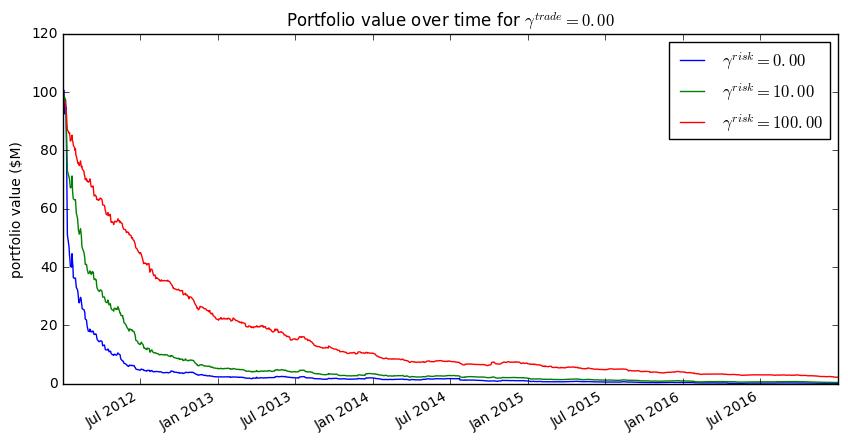

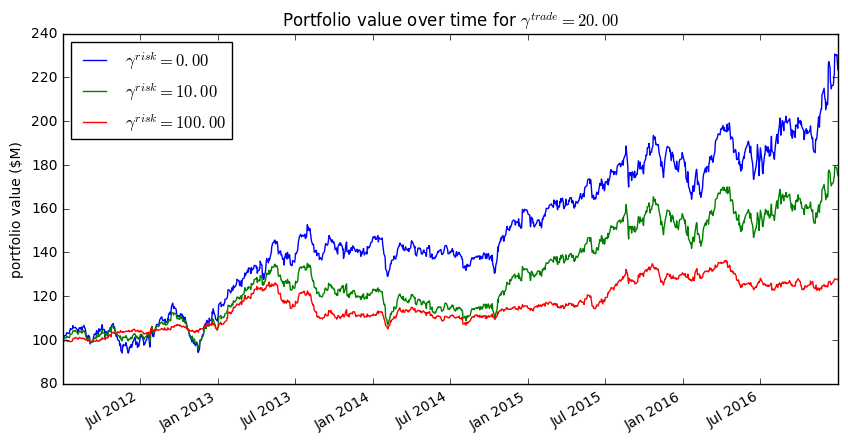

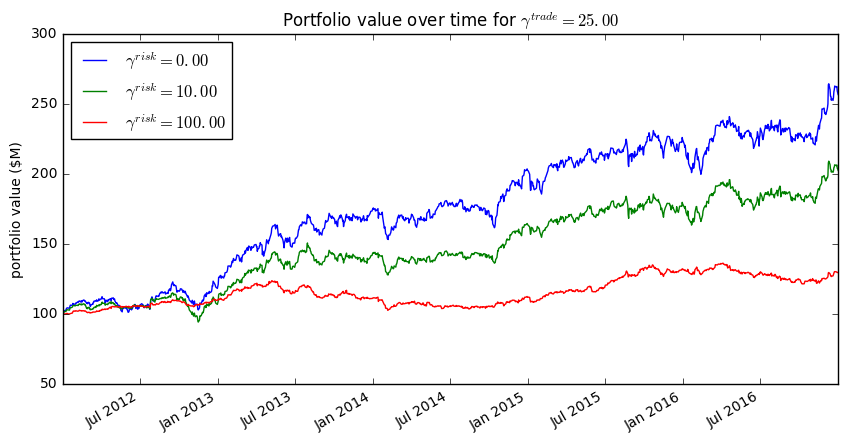

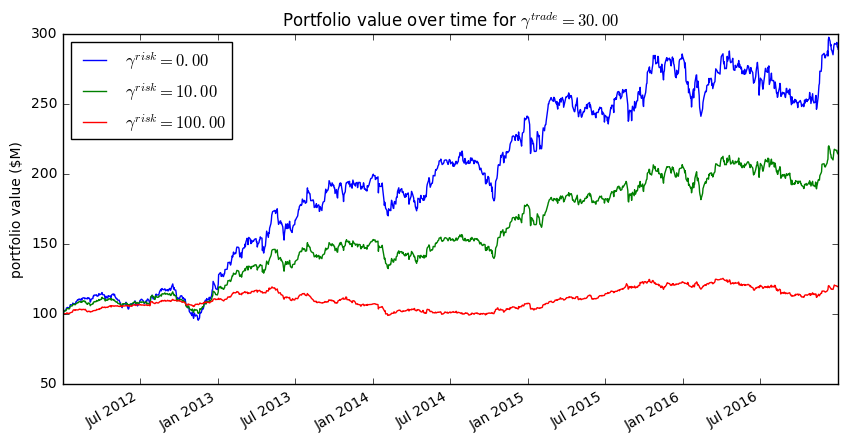

In [15]:
for i in range(4):
    gamma_tcost = gamma_tcosts[i]
    plt.figure(figsize=(10,5))
    [(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^{risk} = %.2f$'%i) for i in gamma_risks]
    plt.legend(loc='upper right' if i==0 else 'upper left')
    plt.ylabel('portfolio value (\$M)')
    plt.title('Portfolio value over time for $\gamma^{trade} = %.2f$'%gamma_tcost)
    plt.savefig(plotdir+'spo_valueintime_gammatrade%d.png'%i)

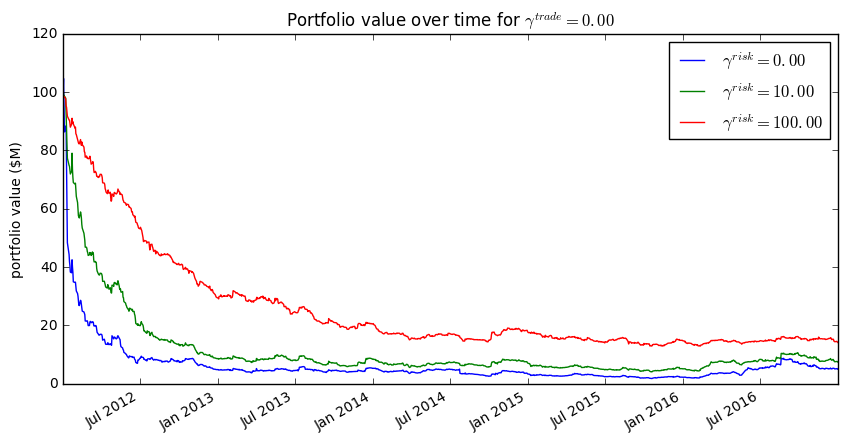

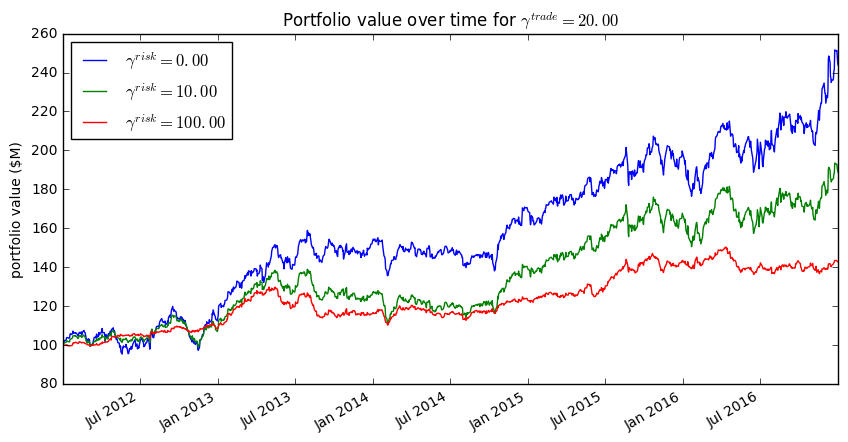

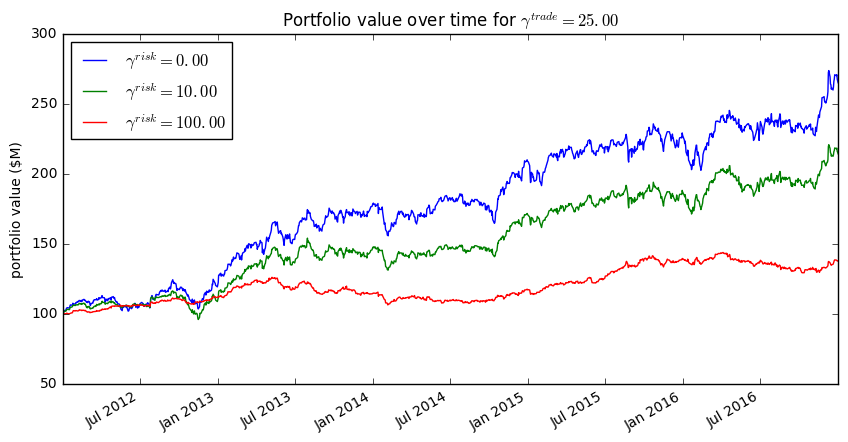

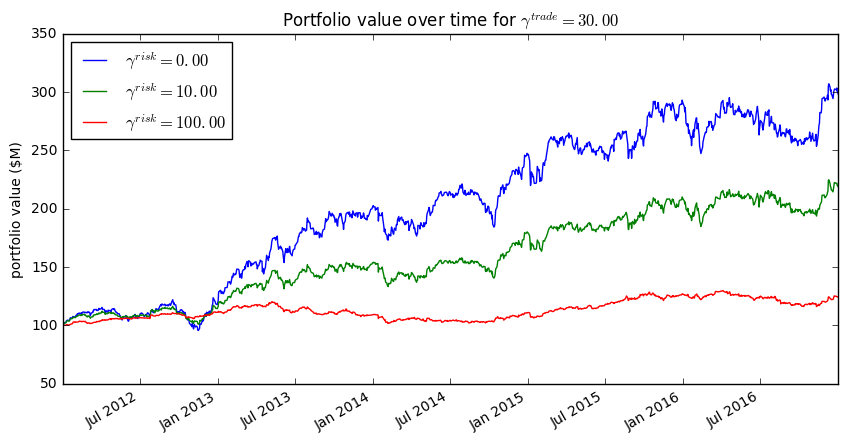

In [17]:
for i in range(4):
    gamma_tcost = gamma_tcosts[i]
    plt.figure(figsize=(10,5))
    [(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^{risk} = %.2f$'%i) for i in gamma_risks]
    plt.legend(loc='upper right' if i==0 else 'upper left')
    plt.ylabel('portfolio value (\$M)')
    plt.title('Portfolio value over time for $\gamma^{trade} = %.2f$'%gamma_tcost)
    plt.savefig(plotdir+'spo_valueintime_gammatrade%d.png'%i)

## Other diagnostics

([0.0, 10.0, 100.0], 40.0)

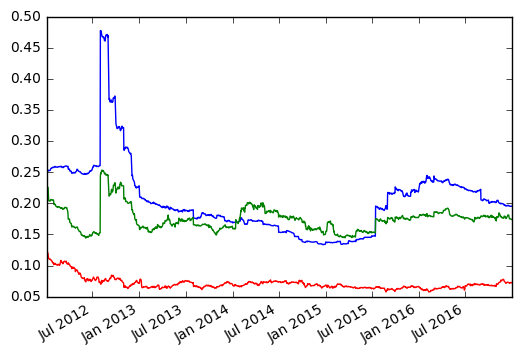

In [15]:
gamma_tcost=gamma_tcosts[-1]
[(np.sqrt(250)*np.sqrt(results[(i, gamma_tcost)].policy_FactorModelSigma)).plot() for i in gamma_risks]
gamma_risks, gamma_tcost

([0.0, 10.0, 100.0], 25.0)

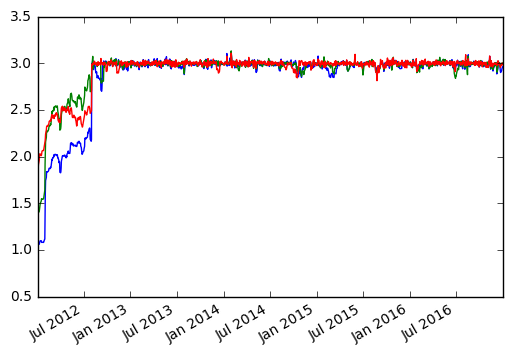

In [17]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([0.0, 10.0, 100.0], 20.0)

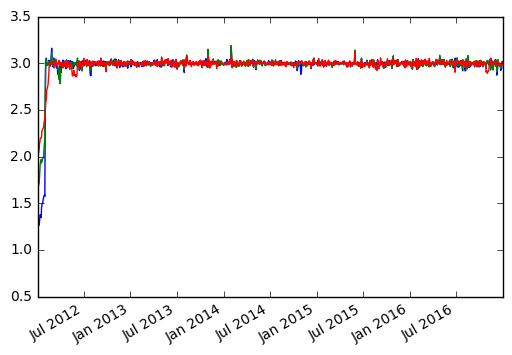

In [20]:
[results[(i, gamma_tcosts[1])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[1]

([0.0, 10.0, 100.0], 25.0)

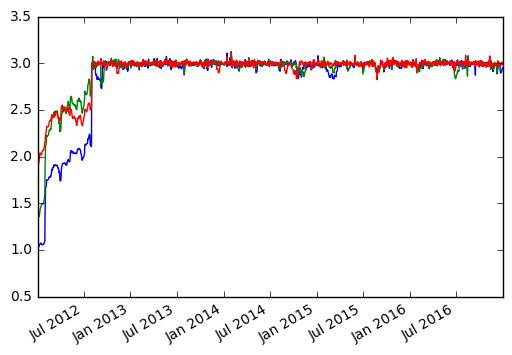

In [21]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([0.0, 10.0, 100.0], 25.0)

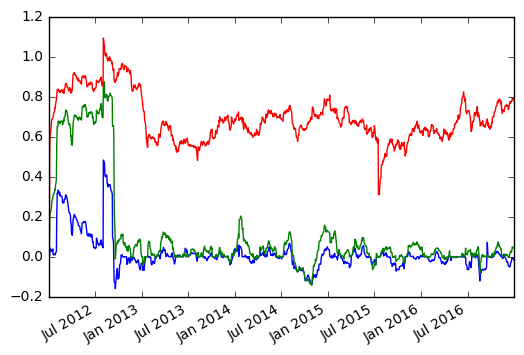

In [22]:
[results[(i, gamma_tcosts[2])].w.USDOLLAR.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([0.0, 10.0, 100.0], 25.0)

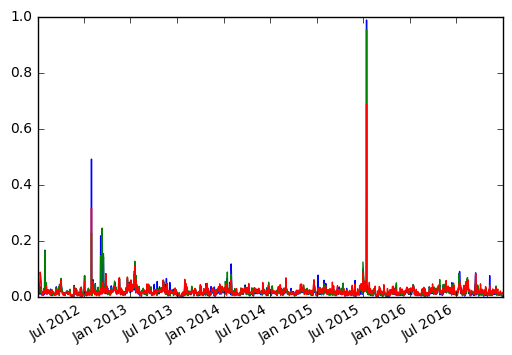

In [23]:
[results[(i, gamma_tcosts[2])].turnover.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [24]:
res.turnover.plot()
res.policy_TcostModel.sum(1).plot(secondary_y=True)

NameError: name 'res' is not defined

In [ ]:
res.policy_TcostModel.sum(1).plot()
res.simulator_TcostModel.sum(1).plot(secondary_y=True)

In [ ]:
(res.policy_TcostModel.sum(1)).tail(100).plot(style='.-')
(res.simulator_TcostModel.sum(1)/res.v).tail(100).plot(style='.-')